Import the libraries

In [1]:
import collections
from ortools.sat.python import cp_model
import math

Define data for problem

In [2]:
import json
with open('hayday_goods.json','r') as file:
    raw_data = json.load(file)

with open('my_machines.json','r') as file:
    my_machines = json.load(file)

with open('my_goods.json','r') as file:
    my_goods = json.load(file)

all_machines = []

for item_name, details in raw_data.items():
    if(details['machine'] not in all_machines):
        all_machines.append(details['machine'])

machines_count = len(all_machines)

declare the model

In [3]:
model = cp_model.CpModel()

Define the variables

In [ ]:
class Task:
    def __init__(self,id, name, start, end, machine, presence, l_presence, parent):
        self.id = id
        self.name = name
        self.start = start
        self.end = end
        self.machine = machine
        self.presence = presence
        self.l_presence = l_presence
        self.parent = parent

goods_data = ['Bacon']

machine_to_intervals = collections.defaultdict(list)
good_to_presence = collections.defaultdict(list)

queue = []
horizon = 1000                                                                           
id = 0
all_tasks = []

for good in goods_data:
    queue.append((good, id,-1))
    id += 1

while len(queue) != 0:
    current_name, current_id, parent_id = queue.pop(0)
    start_var = model.new_int_var(0,horizon,"start"+str(current_id))
    end_var = model.new_int_var(0,horizon,"end"+str(current_id))
 
    presence_var = model.new_bool_var(f"presence{current_id}")
    interval_var = model.new_optional_interval_var(
        start_var, raw_data[current_name]['time'], end_var, presence_var, "interval"+str(current_id)
    )
    machine_var = model.new_int_var(0,len(all_machines),"machine"+str(current_id))
    
    l_presences = []
    num_specific_my_machines = my_machines[raw_data[current_name]['machine']]['number']
    for i in range(num_specific_my_machines):
        l_start_var = model.new_int_var(0,horizon,"l_start"+ str(i)+str(current_id))
        l_end_var = model.new_int_var(0,horizon,"l_end"+str(i)+str(current_id))
        l_presence = model.new_bool_var(f"l_presence_Field_{str(i)}_{str(current_id)}")
        l_interval_var = model.new_optional_interval_var(
            l_start_var, raw_data[current_name]['time'], l_end_var, l_presence, "interval"+str(current_id)
        )
        
        model.Add(start_var == l_start_var).OnlyEnforceIf(l_presence)
        model.Add(end_var == l_end_var).OnlyEnforceIf(l_presence)
        model.Add(machine_var == i).OnlyEnforceIf(l_presence)
        l_presences.append(l_presence)
        machine_to_intervals[raw_data[current_name]['machine']+str(i)].append(l_interval_var)
    model.add_exactly_one(l_presences)
    good_to_presence[current_name].append(presence_var)

    all_tasks.append(Task(id,current_name,start_var,end_var,machine_var, presence_var,l_presences,parent_id))

     

    if(parent_id != -1):
        model.add(

            all_tasks[parent_id].start >= all_tasks[current_id].end
        ).OnlyEnforceIf(presence_var)
        #id_to_parent.append(parent_id)
        parent_presence = all_tasks[all_tasks[current_id].parent].presence   
       # model.AddImplication(parent_presence.Not(), presence_var.Not())#martin
    

    for ing, ing_qty in raw_data[current_name]['ingredients'].items():
        if(ing == current_name):
            break
        else:
            for i in range(ing_qty):
                queue.append((ing, id, current_id))
                id += 1
                

for good in good_to_presence.keys():
    if(good in my_goods):
        model.Add(sum(good_to_presence[good]) >= max(len(good_to_presence[good]) - int(my_goods[good]['number']),0))
    else:
        print(len(good_to_presence[good]) )
        model.Add(sum(good_to_presence[good]) >= len(good_to_presence[good]) )


2
1


Define the constraints

In [ ]:
import re

def get_trailing_number(s):
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group(0)) # Convert the matched string to an integer
    else:
        return None

for machine in machine_to_intervals.keys():
    model.add_no_overlap(machine_to_intervals[machine])

for machine in machine_to_intervals.keys():

    intervals = machine_to_intervals[machine]

    for i in intervals:
        for j in intervals:
            if(i != j):
                id_i = int(i.Name()[len("interval"):])
                id_j = int(j.Name()[len("interval"):])

                good_i = all_tasks[id_i].name
                good_j = all_tasks[id_j].name

                presence_i = all_tasks[id_i].presence
                presence_j = all_tasks[id_j].presence
               
               
                a =  model.NewBoolVar('a')
                model.add(all_tasks[id_j].start >= all_tasks[id_i].end).OnlyEnforceIf(a)
                model.add(all_tasks[id_j].start < all_tasks[id_i].end).OnlyEnforceIf(a.Not())
                b = model.NewBoolVar('b')
                model.add(all_tasks[id_i].start >= all_tasks[id_j].end).OnlyEnforceIf(b)
                model.add(all_tasks[id_i].start < all_tasks[id_j].end).OnlyEnforceIf(b.Not())
                
                model.AddBoolOr(a,b).OnlyEnforceIf(presence_i, presence_j, all_tasks[id_i].l_presence[get_trailing_number(machine)],all_tasks[id_j].l_presence[get_trailing_number(machine)])

Define the objective

In [ ]:
obj_var = model.new_int_var(0, horizon, "makespan")

cand_ends = []
for i in range(id):
    # 1) create a candidate‑end var that will be either end_i or 0
    c = model.NewIntVar(0, horizon, f"cand_end_{i}")
    # if task i is present → candidate == real end
   
    model.Add(c == all_tasks[i].end).OnlyEnforceIf(all_tasks[i].presence)
    # if task i is absent  → candidate == 0 (or any safe lower bound)
    model.Add(c == 0).OnlyEnforceIf(all_tasks[i].presence.Not())
    cand_ends.append(c)

# 2) now max over those “masked” ends
model.AddMaxEquality(obj_var, cand_ends)
model.minimize(obj_var)

invoke solver

In [8]:
solver = cp_model.CpSolver()

  
status = solver.solve(model)
print(solver.Value(obj_var))


40


display results

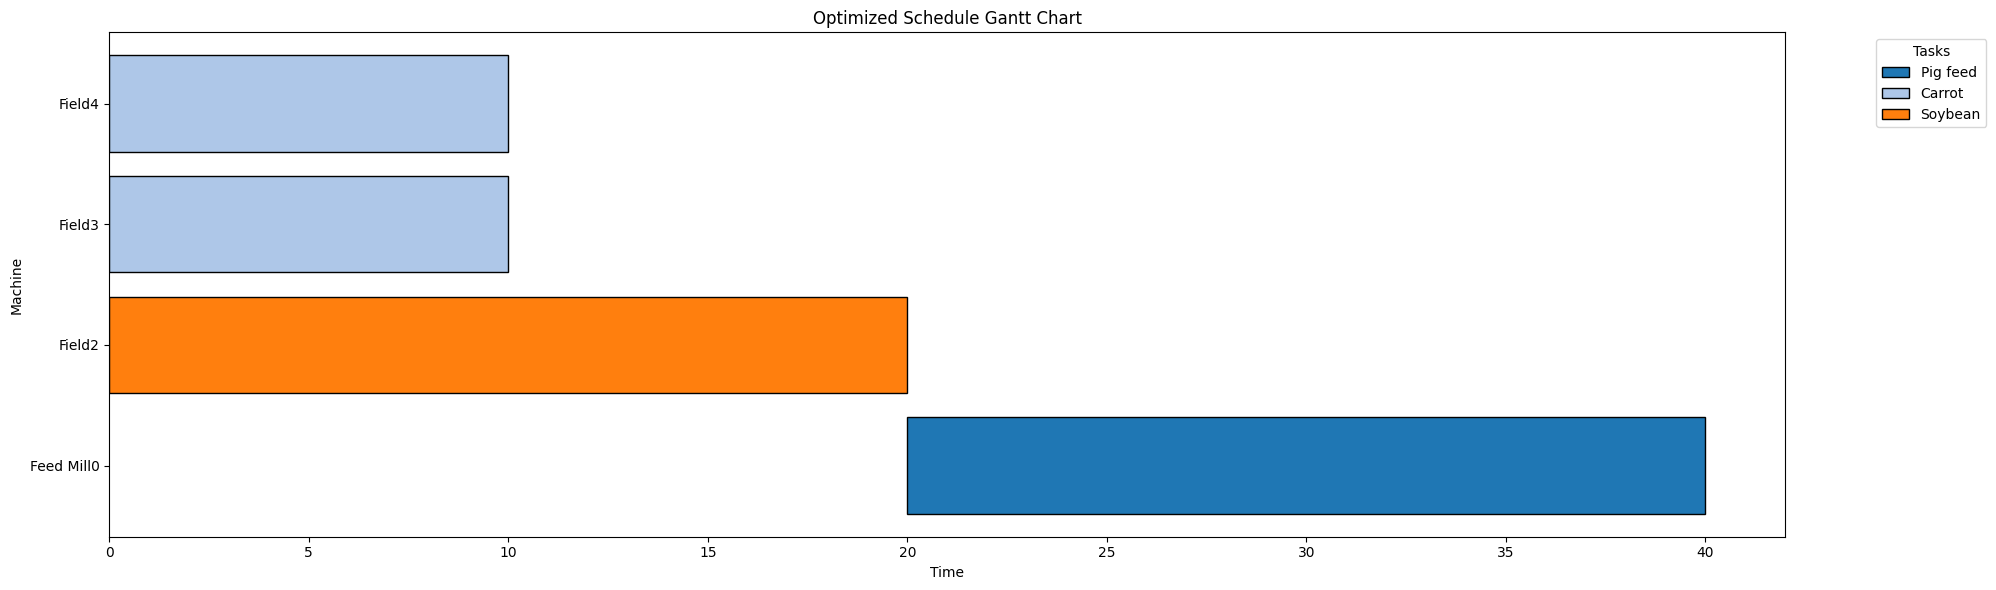

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # Collect schedule data for plotting
    schedule_data = []
    for i in range(id):
        if(solver.Value(all_tasks[i].presence)):
            start = solver.Value(all_tasks[i].start)
            end = solver.Value(all_tasks[i].end)
            machine = raw_data[all_tasks[i].name]['machine']+ str(solver.Value(all_tasks[i].machine))
            schedule_data.append((all_tasks[i].name, start, end, machine))
     
    fig, ax = plt.subplots(figsize=(20, 6))  # Wider figure for visibility

    # Unique machine list and positions
    machines = sorted(set(item[3] for item in schedule_data))
    y_positions = {machine: idx for idx, machine in enumerate(machines)}

    # Assign colors by task name
    colors = {}
    for idx, (task_name, _, _, _) in enumerate(schedule_data):
        if task_name not in colors:
            colors[task_name] = plt.cm.tab20(len(colors) % 20)

    # Draw bars with scaling
    for task_name, start, end, machine in schedule_data:
        
        ax.barh(
            y_positions[machine],
            (end - start),
            left=start,
            color=colors[task_name],
            edgecolor='black'
        )

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=task)
                       for task, color in colors.items()]
    ax.legend(handles=legend_elements, title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format chart
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel(f"Time")
    ax.set_ylabel("Machine")
    ax.set_title("Optimized Schedule Gantt Chart")
    plt.tight_layout()
    plt.show()
else:
    print("fuck")
